In [1]:
import pandas as pd
import numpy as np

import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import os
os.chdir('C:/Users/Home/Desktop/vyučovaní/Programovani/1 Letni semestr 2 rocnik/PPM2/uloha3')

## 1. Stahujeme tabulky s potrebnymi data csv

In [2]:
df_diagnostic = pd.read_excel("scr/Diagnostics.xlsx")
df_anomalie = pd.read_excel("scr/RhythmNames.xlsx")

### 1.1 Ulozime nazvy sloupcu pro kazdou stabulek pro snadny pristup

In [3]:
diagnostic_naz_sloupcu = df_diagnostic.keys()
anomalie_naz_sloupcu = df_anomalie.keys()
# df_anomalie[anomalie_naz_sloupcu[1]][:]
df_diagnostic[diagnostic_naz_sloupcu[0]][:]

0        MUSE_20180113_171327_27000
1        MUSE_20180112_073319_29000
2        MUSE_20180111_165520_97000
3        MUSE_20180113_121940_44000
4        MUSE_20180112_122850_57000
                    ...            
10641    MUSE_20181222_204306_99000
10642    MUSE_20181222_204309_22000
10643    MUSE_20181222_204310_31000
10644    MUSE_20181222_204312_58000
10645    MUSE_20181222_204314_78000
Name: FileName, Length: 10646, dtype: object

## 2. Ulozime jenom sloupce nazvy filu pacientu a jejich nemoci SB nebo AFIB

In [4]:
SB_a_AFIB_nazvy_souboru = []

for i in range(len(df_diagnostic[diagnostic_naz_sloupcu[0]][:])):
    if df_diagnostic[diagnostic_naz_sloupcu[1]][i] == "SR" or  df_diagnostic[diagnostic_naz_sloupcu[1]][i] == "AFIB":
        pacient = [ df_diagnostic[diagnostic_naz_sloupcu[0]][i], df_diagnostic[diagnostic_naz_sloupcu[1]][i] ]
        SB_a_AFIB_nazvy_souboru.append(pacient)

In [5]:
print(SB_a_AFIB_nazvy_souboru[0:5])
print(len(SB_a_AFIB_nazvy_souboru))
print(type(SB_a_AFIB_nazvy_souboru))

[['MUSE_20180113_171327_27000', 'AFIB'], ['MUSE_20180114_075026_69000', 'AFIB'], ['MUSE_20180209_172046_21000', 'SR'], ['MUSE_20180113_133901_16000', 'AFIB'], ['MUSE_20180209_122707_18000', 'SR']]
3606
<class 'list'>


## 3. Stahujeme signaly pacientu 

X_data - data signalu 

y_data - SB = 1, AFIB = 0

In [6]:
data = []
y_data = []
for i in range(len(SB_a_AFIB_nazvy_souboru)):
    nemoc = SB_a_AFIB_nazvy_souboru[i][1]
    soubor = SB_a_AFIB_nazvy_souboru[i][0]
    match nemoc:
        case "AFIB":
            y_data.append(0)
        case "SR":
            y_data.append(1)
    signal_pacienta = pd.read_csv(f"data_sigmalu/ECGDataDenoised/{soubor}.csv",usecols=[0], names = ["a"])
    data.append(signal_pacienta)

Pri stazeni mame 3 Dim chceme 2 Dim

In [7]:
data = np.array(data)
shape_data = data.shape 
data = data.reshape(shape_data[0], shape_data[1])
print(data.shape)

y_data = np.array(y_data)
print(y_data.shape)
print(data[0])
print(y_data[0])

(3606, 5000)
(3606,)
[ 56.108  54.815  52.412 ... -36.262 -27.011 -14.391]
0


In [8]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data)

x_train, x_test, y_train, y_test = train_test_split(data_scaled, y_data, test_size=0.2)

In [9]:
print(x_train[0].shape)
print(y_train.shape)

(5000,)
(2884,)


In [10]:
# model = train_model(x_train, y_train, x_test, y_test, config['layers'], config['neurons'], config['activation'])
# loss = evaluate_model(model, x_test, y_test)

## Vytvareni Modelu

In [11]:
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Dense

# def create_model(layers, neurons, activation):
#     model = Sequential()
#     model.add(Dense(neurons, input_dim = 1, activation=activation))
#     for _ in range(1, layers):
#         model.add(Dense(neurons, activation=activation))
#     model.add(Dense(1))
#     return model


# def train_model(x_train, y_train, x_val, y_val, layers, neurons, activation):
#     model = create_model(layers, neurons, activation)
#     model.compile(optimizer='adam', loss='mse')
#     model.fit(x_train, y_train, validation_data=(x_val, y_val), epochs=4000, verbose = 0)
#     return model

# def evaluate_model(model, x_test, y_test):
#     loss = model.evaluate(x_test, y_test, verbose=0)
#     return loss

In [21]:
x_train[0].shape

(5000,)

y_data - SB = 1, AFIB = 0

In [34]:
y_train[:5] # 0

array([1, 0, 1, 0, 0])

In [40]:
from scipy.fft import fft

y = [ fft(x_train[i][:2500]) for i in range(5)]

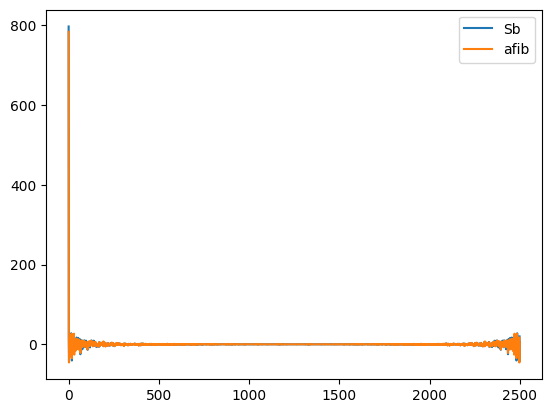

In [41]:
import matplotlib.pyplot as plt

plt.plot(y[0], label = "Sb")
plt.plot(y[1], label = "afib")
plt.legend()

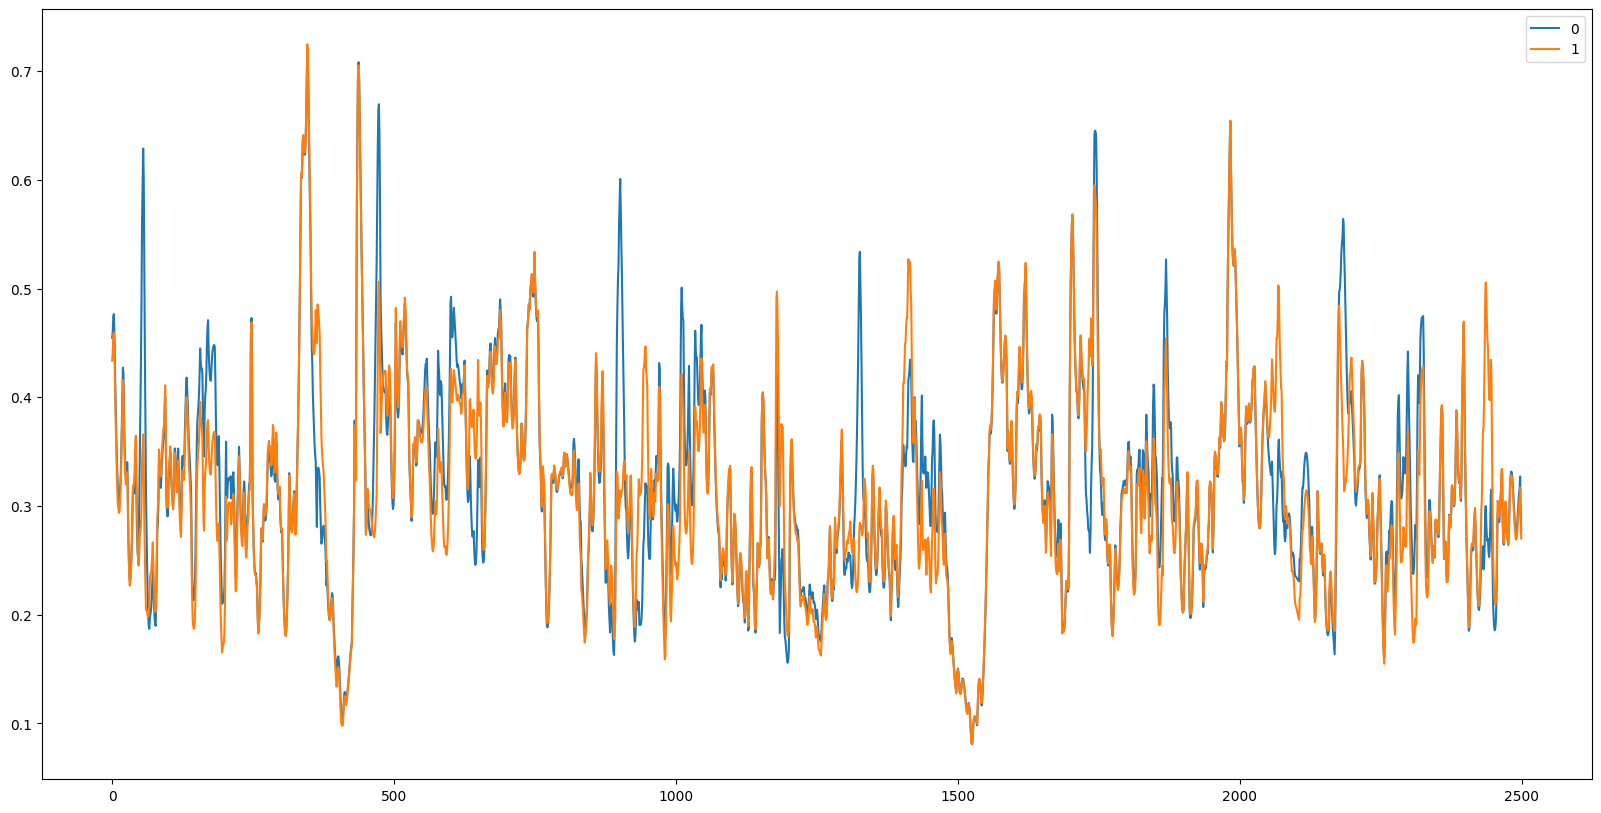

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize= (20,10))
plt.plot(x_train[0][:2500], label = "0")
plt.plot(x_train[1][:2500], label = "1")
plt.legend()

In [23]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape = x_train[0].shape),

  tf.keras.layers.Dense(256, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  
  tf.keras.layers.Dense(1, activation = 'sigmoid')
])

In [24]:
from tensorflow.keras.callbacks import ModelCheckpoint

In [25]:
# ucelova_fce = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=['accuracy'])
checkpoint = ModelCheckpoint(filepath=f"scr/model_ekg.keras", save_best_only=True)

In [26]:
history = model.fit(x_train, y_train,
                    epochs=10,
                    validation_data=(x_test, y_test),
                    callbacks=[checkpoint],
                    verbose = 1)

Epoch 1/10


91/91 [==============================] - 6s 25ms/step - loss: 0.7576 - accuracy: 0.4969 - val_loss: 0.6937 - val_accuracy: 0.5111
Epoch 2/10
91/91 [==============================] - 2s 19ms/step - loss: 0.6997 - accuracy: 0.5208 - val_loss: 0.6952 - val_accuracy: 0.5111
Epoch 3/10
91/91 [==============================] - 2s 20ms/step - loss: 0.7015 - accuracy: 0.4861 - val_loss: 0.6930 - val_accuracy: 0.5111
Epoch 4/10
91/91 [==============================] - 2s 21ms/step - loss: 0.6961 - accuracy: 0.4958 - val_loss: 0.6929 - val_accuracy: 0.5111
Epoch 5/10
91/91 [==============================] - 2s 19ms/step - loss: 0.6937 - accuracy: 0.5059 - val_loss: 0.6931 - val_accuracy: 0.5111
Epoch 6/10
91/91 [==============================] - 2s 19ms/step - loss: 0.6932 - accuracy: 0.5049 - val_loss: 0.6931 - val_accuracy: 0.5111
Epoch 7/10
91/91 [==============================] - 2s 19ms/step - loss: 0.6931 - accuracy: 0.5052 - val_loss: 0.6931 - val_accuracy: 0.5111
Epoch 8/10


23/23 - 0s - loss: 0.6930 - accuracy: 0.5111 - 109ms/epoch - 5ms/step


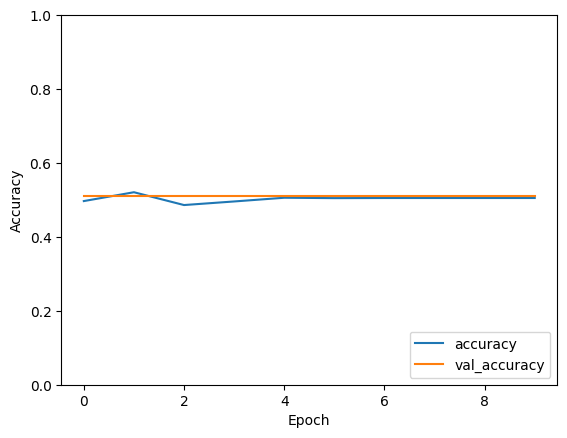

In [27]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

In [28]:
# y_pred = model.predict(x_scaled)